#  **ICT303 - Assignment 2**

**Your name: Seah Wen Long**

**Student ID: 35134977**

**Email: seahwenlong2@gmail.com**






# **1. Problem Statement**

In this assignment, we will be performing **text analysis**, which is the process of automatically extracting and classifying information from textual data to gain insights and understand patterns.

Spam detection is one of the common application of text analysis, where the goal is to distinguish between spam (unsolicited messages such as advertisements, scams, or harmful content) and ham (legitimate messages).

In this project, we aim to build and evaluate whether a **Long Short-Term Memory (LSTM)** or a **Naive Bayes** model provides the highest accuracy and precision in automatically classify SMS messages as spam or ham.

# **2. Device Set up**

## 2.1. Installing and Importing Libraries

We will import and install all the neccessary libraries.

In [ ]:
!pip install supervision tensorflow torchview

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.2 MB/s eta 0:00:00


In [ ]:
# General
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import random
import warnings
warnings.filterwarnings('ignore')

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

# Sklearn for Naive Bayes and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# LSTM (keras)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# LSTM (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

# Visualization
from IPython.display import Image
from torchview import draw_graph

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2.2. Initializing GPU
Ensure that GPU setting is enabled for faster training time

In [ ]:
# GPU initialization
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **3. Dataset**


## 3.1. Dataset Description

The dataset is taken from Kaggle, with its original from:
Almeida, T. & Hidalgo, J. (2011). SMS Spam Collection [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5CC84.

The dataset contains 1 SMS messages per line which includes two columns:
*   Labels: 'ham' or 'spam'
*   SMS: Content of the messages

Each SMS message is labelled 'ham' or 'spam' with each value being unique.


## 3.2. Downloading Dataset

For easier access to data, dataset for Assignment 2 have been uploaded to github.

By using git clone, data can be downloaded from my github page.

To ensure that the dataset is correct, pandas will be used to read and view the first few rows of the data.

In [ ]:
# Clone the repository from GitHub
!git clone https://github.com/wen-long123/ICT303_Data.git

# Define the path to the CSV file
dataset_path = './ICT303_Data/Assignment2_Datasets/spam.csv'

# Read the CSV file using pandas
df = pd.read_csv(dataset_path, encoding='latin-1')  # Latin-1 encoding handles special characters
df = df[['v1', 'v2']]  # Only keep the label and message columns
df.columns = ['label', 'message']  # Rename columns for clarity

# Preview the first few rows
df.head()

Cloning into 'ICT303_Data'...
remote: Enumerating objects: 3864, done.
remote: Counting objects: 100% (3864/3864), done.
remote: Compressing objects: 100% (3858/3858), done.
remote: Total 3864 (delta 3), reused 3853 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (3864/3864), 40.23 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (3/3), done.


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### 3.2.1. Data Information

After the loading of datasets, we examine its structure and quality to understand the content and identify any potential issues.

### Dataset Info ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


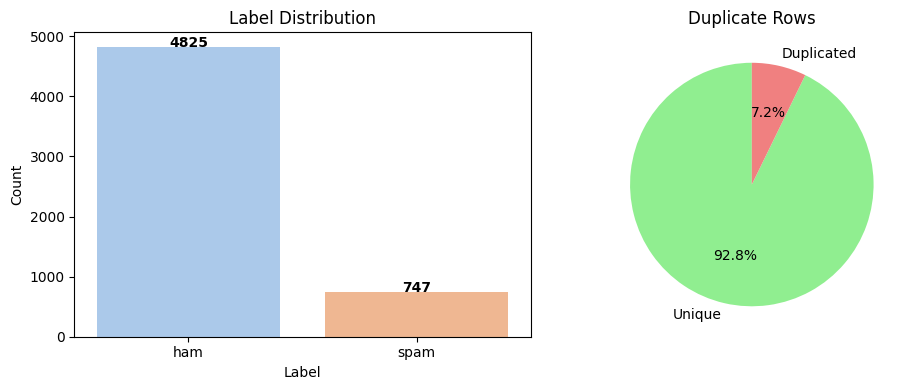


### Null Values in Each Column ###
label      0
message    0
dtype: int64


In [ ]:
# Display dataset info
print("### Dataset Info ###")
df.info()

# Prepare data
label_counts = df['label'].value_counts()
duplicate_count = df.duplicated().sum()
unique_count = len(df) - duplicate_count

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Smaller layout

# Label Distribution
sns.barplot(x=label_counts.index, y=label_counts.values, palette='pastel', ax=axes[0])
axes[0].set_title("Label Distribution")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Duplicate Proportion
axes[1].pie([unique_count, duplicate_count],
            labels=["Unique", "Duplicated"],
            autopct='%1.1f%%',
            startangle=90,
            colors=["lightgreen", "lightcoral"])
axes[1].set_title("Duplicate Rows")

plt.tight_layout()
plt.show()

# Check for null values
print("\n### Null Values in Each Column ###")
print(df.isnull().sum())

## 3.3. Data Cleaning & Preprocessing

To prevent data leakage or inconsistencies, data cleaning and preprocessing are essential steps before feeding the data into the models. The steps for data cleaning includes:
- Removing null or duplicate entries
- Lowercasing texts
- Remove punctuation
- Tokenization
- Remove stopwords, eg. common non-informative words like 'is', 'the', 'a'
- Stemming, eg. reduces words to root (e.g., "running" → "run")
- Encoding ham and spam to 0 and 1 respectively

This ensures that the dataset is clean, standardized, and ready for model training, allowing algorithms to focus on the most informative features and improving overall classification accuracy.

In [ ]:
# Remove duplicated values
df.drop_duplicates(inplace=True)

# Encode label: ham = 0, spam = 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Initialize tools
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Count ham and spam entries
print("\n### Label Distribution ###")
print(df['label'].value_counts())

# Check for duplicated rows
print("\n### Number of Duplicated Entries ###")
print(f"{df.duplicated().sum()}")

# Apply clean text
df['cleaned'] = df['message'].apply(clean_text)

# Preview the first few rows
df[['label', 'message', 'cleaned']].head()


### Label Distribution ###
label
0    4516
1     653
Name: count, dtype: int64

### Number of Duplicated Entries ###
0


,label,message,cleaned
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


## 3.4. Data Splitting

In this section, we will split the dataset into the following:
- Training Data: 70%
- Validation Data: 20%
- Test Data: 10%

By splitting the dataset into this way, we ensure that:
- The model have sufficient examples for **training** and learning.
- The **validation data** helps in the evaluation of the model.
- The **test data** acts as a benchmark to assess the performance of each model for comparison.

We will first split 70% of the data for training and 30% as a temporary set. The temporary set will be further split into 20% for validation and 10% for testing. Lastly, using stratify to ensures label distribution is preserved across splits

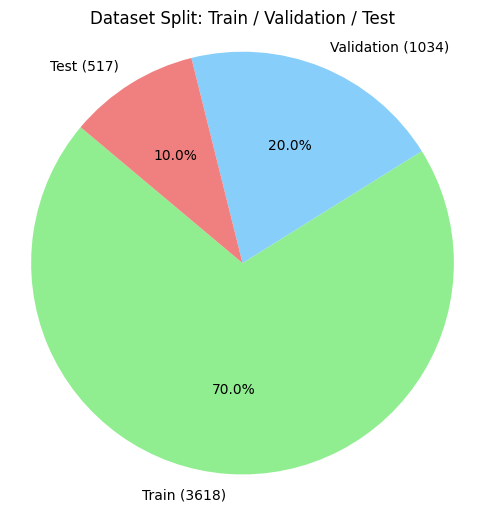

In [ ]:
# Define features and labels
x = df['cleaned']
y = df['label']

# Split dataset into Train (70%) and Temp (30%)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

# Split Temp into Validation (20%) and Test (10%)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

# ==== Display Set Size ====
# Get dataset sizes
train_size = len(x_train)
val_size = len(x_val)
test_size = len(x_test)

# Pie chart values and labels
sizes = [train_size, val_size, test_size]
labels = [f'Train ({train_size})', f'Validation ({val_size})', f'Test ({test_size})']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Dataset Split: Train / Validation / Test")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

## 3.5. Data Preparation
Since there are three different models, we prepared the data separately to suit the input requirements of each model.

### 3.5.1. Preparation for Naive Bayes model

TF-IDF also known as Term Frequency-Inverse Document Frequency is a tool used in NLP to convert text data into numerical features. It assigns importance score to words based on their frequency in a message relative to their frequency across all messages.

In [ ]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit on training data and transform all sets
x_train_tfidf = tfidf.fit_transform(x_train)
x_val_tfidf = tfidf.transform(x_val)
x_test_tfidf = tfidf.transform(x_test)

### 3.5.2. Preparation for Keras LSTM

For LSTM, we used Keras's `Tokenizer` to convert the cleaned text messages into integer sequences, where each unique word is mapped to a unique index.

All sequences were padded to a fixed length (`max_len = 100`) using Keras's `pad_sequences` function to ensure uniform input shape for the model.

Finally, the padded sequences and labels were converted to NumPy arrays to prepare them for model training using Keras.

In [ ]:
# Initialize tokenizer and fit on training text
lstm_tokenizer = Tokenizer()
lstm_tokenizer.fit_on_texts(x_train)

# Convert text to sequences
x_train_seq = lstm_tokenizer.texts_to_sequences(x_train)
x_val_seq = lstm_tokenizer.texts_to_sequences(x_val)
x_test_seq = lstm_tokenizer.texts_to_sequences(x_test)

# Pad sequences to fixed length
max_len = 100
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

# Convert labels to numpy arrays
y_train_array = y_train.values
y_val_array = y_val.values
y_test_array = y_test.values

### 3.5.3. Preparation for PyTorch LSTM

For PyTorch LSTM, we tokenized each cleaned message using simple whitespace splitting (.split()), built a vocabulary from the training set, and added special tokens (<PAD>, <UNK>) to handle padding and unknown words.

Each message was then converted into a sequence of word indices and padded to ensure uniform length. Finally, the sequences and corresponding labels were converted into PyTorch tensors to prepare them for model training.

In [ ]:
# Step 1: Build vocabulary from training set using .split() on cleaned text
word2idx = {'<PAD>': 0, '<UNK>': 1}  # special tokens
idx = 2

for text in x_train:
    for word in text.split():  # cleaned, preprocessed text
        if word not in word2idx:
            word2idx[word] = idx
            idx += 1

# Vocabulary size
vocab_size = len(word2idx)
print(f"Vocabulary Size: {vocab_size}")

# Step 2: Function to convert a cleaned sentence to a sequence of word indices
def encode(text):
    return [word2idx.get(word, word2idx['<UNK>']) for word in text.split()]

# Step 3: Encode all text datasets
x_train_encoded = [torch.tensor(encode(text)) for text in x_train]
x_val_encoded   = [torch.tensor(encode(text)) for text in x_val]
x_test_encoded  = [torch.tensor(encode(text)) for text in x_test]

# Step 4: Pad sequences to ensure equal length
x_train_padded_pt = pad_sequence(x_train_encoded, batch_first=True, padding_value=word2idx['<PAD>'])
x_val_padded_pt   = pad_sequence(x_val_encoded, batch_first=True, padding_value=word2idx['<PAD>'])
x_test_padded_pt  = pad_sequence(x_test_encoded, batch_first=True, padding_value=word2idx['<PAD>'])

# Step 5: Convert labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train.values)
y_val_tensor   = torch.tensor(y_val.values)
y_test_tensor  = torch.tensor(y_test.values)

# Step 6: Create TensorDatasets and DataLoaders
# TensorDatasets
train_dataset = TensorDataset(x_train_padded_pt, y_train_tensor)
val_dataset   = TensorDataset(x_val_padded_pt, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_padded_pt, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64)
test_loader   = DataLoader(test_dataset, batch_size=64)

Vocabulary Size: 6446


# **4. Trainer Class**

In this section, we will define custom trainer class for both the Naive Bayes and LSTM models. The purpose of it is to streamline training and evaluation.

## 4.1. Naive Bayes Trainer Class

In [ ]:
class NaiveBayesTrainer:
  def __init__(self, model, x_train, y_train, x_val, y_val):
    self.model = model
    self.x_train = x_train
    self.y_train = y_train
    self.x_val = x_val
    self.y_val = y_val

  def train(self):
    self.model.fit(self.x_train, self.y_train)
    print("Naive Bayes model training complete.")

## 4.2. Keras LSTM Trainer Class

In [ ]:
class LSTMTrainer:
  def __init__(self, x_train, y_train, x_val, y_val, vocab_size, max_len, embedding_dim, hidden_dim, num_epochs, optimizer):
    self.x_train = x_train
    self.y_train = y_train
    self.x_val = x_val
    self.y_val = y_val
    self.vocab_size = vocab_size
    self.max_len = max_len
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.num_epochs = num_epochs
    self.optimizer = optimizer
    self.batch_size = 64

    self.model = build_lstm_model(vocab_size, embedding_dim, max_len, hidden_dim, dropout_rate=0.3)

    self.model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

  def train(self):
    # Use EarlyStopping to avoid overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    # Train model and store training history
    self.history = self.model.fit(
        self.x_train, self.y_train,
        validation_data = (self.x_val, self.y_val),
        epochs = self.num_epochs,
        batch_size = self.batch_size,
        callbacks=[early_stop],
        verbose=1
    )

  def plot_training_curves(self):
    history = self.history.history

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 4.3. PyTorch LSTM Trainer Class

In [ ]:
class PyTorchLSTMTrainer():
  def __init__(self, model, device, train_data, val_data, num_epochs, optimizer, criterion=None):
    self.model = model
    self.device = device
    self.train_data = train_data
    self.val_data = val_data
    self.num_epochs = num_epochs
    self.optimizer = optimizer
    self.criterion = criterion if criterion is not None else nn.BCELoss()
    self.model.to(self.device)

  def train(self):
    for epoch in range(self.num_epochs):
      self.model.train()
      total_train_loss, correct_train, total_train = 0, 0, 0

      for inputs, labels in self.train_data:
        inputs, labels = inputs.to(self.device), labels.to(self.device).float()

        outputs = self.model(inputs).squeeze()
        loss = self.criterion(outputs, labels)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        total_train_loss += loss.item()
        predicted = (outputs > 0.5).int()
        correct_train += (predicted == labels.int()).sum().item()
        total_train += labels.size(0)

      train_loss = total_train_loss / len(self.train_data)
      train_accuracy = 100 * correct_train / total_train

      val_loss, val_accuracy = self.validate()
      print(f'Epoch [{epoch+1}/{self.num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, 'f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

  def validate(self):
    self.model.eval()
    total_val_loss, correct_val, total_val = 0, 0, 0

    with torch.no_grad():
      for inputs, labels in self.val_data:
        inputs, labels = inputs.to(self.device), labels.to(self.device).float()

        outputs = self.model(inputs).squeeze()
        loss = self.criterion(outputs, labels)

        total_val_loss += loss.item()
        predicted = (outputs > 0.5).int()
        correct_val += (predicted == labels.int()).sum().item()
        total_val += labels.size(0)

    val_loss = total_val_loss / len(self.val_data)
    val_accuracy = 100 * correct_val / total_val

    return val_loss, val_accuracy

# **5. Metrics Class**

This section introduces a shared **Metrics** class that is usable for both the Naive Bayes and LSTM models. Since the methods inside the class does not rely on instance-specific data such as `self`, they are defined as **static methods** using the `@staticmethod` decorator. This allows them to be called directly using the class name without creating an instance of the class.

In [ ]:
class Metrics():
  @staticmethod
  def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=["Ham", "Spam"])

    return accuracy, precision, conf_matrix, report

  @staticmethod
  def plot_confusion_matrix(conf_matrix, labels=["Ham", "Spam"]):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# **6. Models**

This section presents the actual implementation, tuning, and evaluation of three machine learning models.

## 6.1. Naive Bayes Model

The Naive Bayes algorithm is a probabilistic classifier based on the Bayes' Theorem with an assumption of feature independence to calculate the probability of a data point belonging to a specific class. It is widely used in text classification due to its simplicity, efficiency and good performance.

There are three types of Naive Bayes Classifier:
- GaussianNB: It assumes that features are normally distributed.
- BernoulliNB: It is normally used for binary or boolean features.
- MultinomialNB: Designed for discrete features such as word counts or TF-IDF scores in text data.

MultinomialNB will be used since our SMS data has been vectorized using the TF-IDF feature. We will manually tune the **alpha** parameter (Laplace Smoothing) with different values to handle unseen words and avoid zero probability errors.

Since it is a non-parametric probabilistic model, the Naive Bayes classifier does not have a model architecture in the form of layers or weights typically seen in deep learning models.

### 6.1.1. Naive Bayes Classifier

In [ ]:
# Initialize Naive Bayes model
nb_model = MultinomialNB()

### 6.1.2. Tuning Hyper Parameters

In [ ]:
# Set Hyperparameter
alpha_value = 0.5
nb_model = MultinomialNB(alpha=alpha_value)

# Training
nb_trainer = NaiveBayesTrainer(nb_model, x_train_tfidf, y_train, x_val_tfidf, y_val)
nb_trainer.train()

# Evaluation
preds = nb_model.predict(x_val_tfidf)
accuracy, precision, conf_matrix, class_report = Metrics.evaluate(y_val, preds)

print(f"Alpha = {alpha_value}")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")

Naive Bayes model training complete.
Alpha = 0.5
Accuracy: 0.9642, Precision: 0.9896


To find the optimal smoothing value **alpha** for the Naive Bayes model, we manually test different values and compare their performance using accuracy and precision.

The following alpha values will be used:
```
alpha: [0.1, 0.5, 1.0, 1.5, 2.0]
```

* **Run 1: alpha = 0.1**
```
Naive Bayes model training complete.
Alpha = 0.1
Accuracy: 0.9720, Precision: 0.9554
```

* **Run 2: alpha = 0.5**
```
Naive Bayes model training complete.
Alpha = 0.5
Accuracy: 0.9642, Precision: 0.9896
```

* **Run 3: alpha = 1.0**
```
Naive Bayes model training complete.
Alpha = 1.0
Accuracy: 0.9507, Precision: 0.9878
```

* **Run 4: alpha = 1.5**
```
Naive Bayes model training complete.
Alpha = 1.5
Accuracy: 0.9381, Precision: 1.0000
```

* **Run 5: alpha = 2.0**
```
Naive Bayes model training complete.
Alpha = 2.0
Accuracy: 0.9246, Precision: 1.0000
```

After testing with multiple different alpha values, the most balanced performance was observed in **Run 2 (alpha = 0.5)**, which achieved:
```
Accuracy: 0.9642
Precision: 0.9896
```
Although **Run 4 & 5** resulted in perfect precision, they have a significantly low accuracy. It indicates that too much smoothing causes underfitting.
Even though **Run 1** had a slightly higher accuracy than **Run 2**, **Run 2** offered a significantly higher precision. Therefore, **Run 2** was chosen as the optimal value for final testing.

### 6.1.3. Display Classification Report & Plotting of Confusion Matrix

              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       903
        Spam       0.99      0.73      0.84       131

    accuracy                           0.96      1034
   macro avg       0.98      0.86      0.91      1034
weighted avg       0.97      0.96      0.96      1034



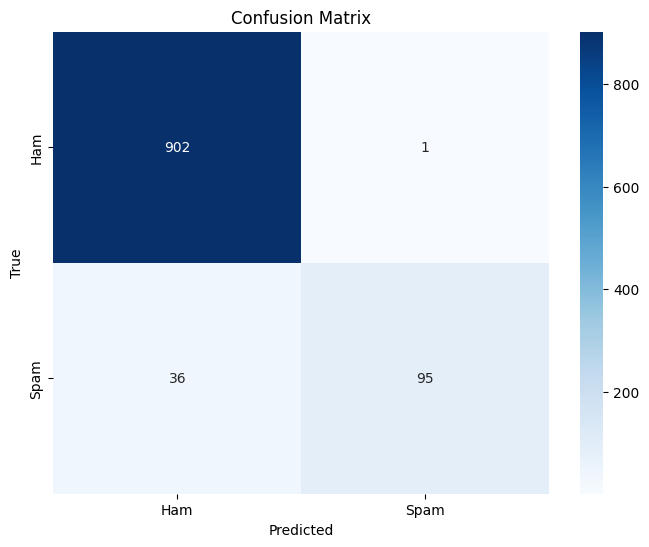

In [ ]:
print(class_report)
Metrics.plot_confusion_matrix(conf_matrix)

### 6.1.4. Checking against Validation data

In [ ]:
# Select 10 random sample
samples = random.sample(list(zip(x_val, y_val, preds)), 10)

print("### Naive Bayes Predictions vs Ground Truth (Validation Set) ###\n")
for i, (msg, true_label, pred_label) in enumerate(samples):
    gt = "Spam" if true_label == 1 else "Ham"
    pred = "Spam" if pred_label == 1 else "Ham"
    print(f"[{i+1}] Message: \"{msg[:60]}...\"")
    print(f"     Ground Truth: {gt} | Predicted: {pred}\n")

### Naive Bayes Predictions vs Ground Truth (Validation Set) ###

[1] Message: "wn u r hurt prsn close 2 u fight wit dem coz somtim di fight..."
     Ground Truth: Ham | Predicted: Ham

[2] Message: "aight text tonight well see what..."
     Ground Truth: Ham | Predicted: Ham

[3] Message: "text pass 69669 collect polyphon rington normal gpr charg ap..."
     Ground Truth: Spam | Predicted: Spam

[4] Message: "beauti tomorrow never come come alreadi today hunt beauti to..."
     Ground Truth: Ham | Predicted: Ham

[5] Message: "ask 3mobil 0870 chatlin inclu free min india cust serv sed y..."
     Ground Truth: Spam | Predicted: Ham

[6] Message: "cant make tonight..."
     Ground Truth: Ham | Predicted: Ham

[7] Message: "worri hope photo shoot went well spif fun workag..."
     Ground Truth: Ham | Predicted: Ham

[8] Message: "great hope like man well endow ltgt inch..."
     Ground Truth: Ham | Predicted: Ham

[9] Message: "fishrman woke earli mrng dark wait amp found sack ful stone 

### 6.1.5. Prediction Distribution and Accuracy breakdown

Since Naive Bayes is non-iterative, tensorboard and training curves are not meaningful. Instead, I will show a chart representing prediction distribution and correctness.

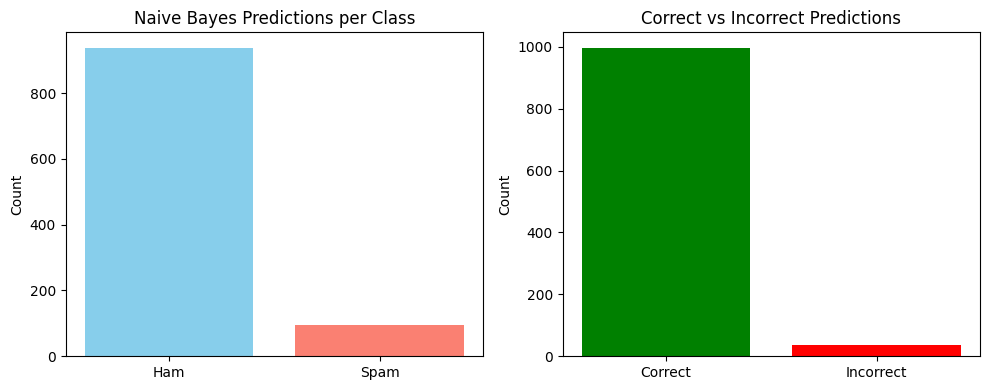

In [ ]:
# Get prediction distribution
unique, counts = np.unique(preds, return_counts=True)
pred_dist = dict(zip(["Ham", "Spam"], counts))

# Ground truth vs predicted comparison
correct = (preds == y_val).sum()
incorrect = len(preds) - correct

# Plot 1: Prediction distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(pred_dist.keys(), pred_dist.values(), color=['skyblue', 'salmon'])
plt.title("Naive Bayes Predictions per Class")
plt.ylabel("Count")

# Plot 2: Accuracy breakdown
plt.subplot(1, 2, 2)
plt.bar(["Correct", "Incorrect"], [correct, incorrect], color=['green', 'red'])
plt.title("Correct vs Incorrect Predictions")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 6.2. Keras LSTM Model

Long Short-Term Memory (LSTM) networks are a special type of recurrent neural network (RNN) capable of learning long-term dependencies, which is highly useful in sequential tasks like text classification.

In this project, we use the Keras API to build and train an LSTM model for SMS spam detection. Keras provides a high-level, easy-to-use interface that supports modular layers, automatic batching, and convenient training utilities.

The key steps include:
- Tokenizing and padding messages into uniform-length sequences.
- Using an `Embedding` layer to represent words in dense vector space.
- Stacking an `LSTM` layer followed by a `Dropout` layer to prevent overfitting.
- Using a `Dense` output layer with sigmoid activation for binary classification.

Keras also supports tools like `EarlyStopping` to prevent overtraining, and `plot_model()` for architecture visualization.


### 6.2.1. Keras LSTM Classifier

In [ ]:
# Calculate vocab size after tokenizer is fit in preprocessing
vocab_size = len(lstm_tokenizer.word_index) + 1

def build_lstm_model(vocab_size, embedding_dim, max_len, hidden_dim, dropout_rate=0.2):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        LSTM(hidden_dim),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

### 6.2.2. Display of Model Architecture

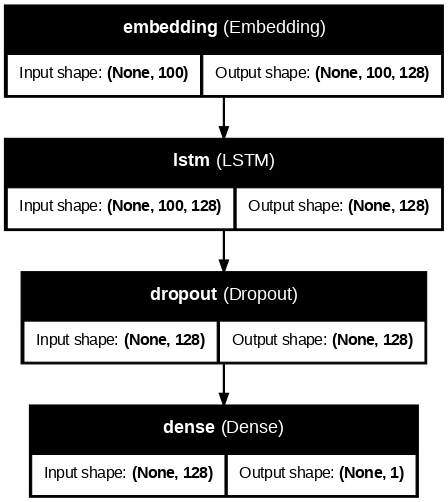

In [ ]:
# Set architecture hyperparameters (reuse those used for training)
embedding_dim = 128
hidden_dim = 128
max_len = 100

# Define the model structure (no training yet)
temp_model = build_lstm_model(vocab_size, embedding_dim, max_len, hidden_dim, dropout_rate=0.5)

# Build the model explicitly so plot_model can read the structure
temp_model.build(input_shape=(None, max_len))

# Visualize the model
plot_model(temp_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True, dpi=80)
Image('lstm_model.png')

### 6.2.3. Tuning of Hyperparameters

In [ ]:
# Set hyperparameters
lstm_lr = 0.001
embedding_dim = 128
hidden_dim = 128

# Fixed Hyperparameters
lstm_epochs = 8
max_len = 100

# Optimizer
lstm_optimizer = Adam(learning_rate=lstm_lr)

lstm_trainer = LSTMTrainer(x_train_pad, y_train_array, x_val_pad, y_val_array, vocab_size, max_len, embedding_dim, hidden_dim, lstm_epochs, lstm_optimizer)
lstm_trainer.train()

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8791 - loss: 0.3527 - val_accuracy: 0.9574 - val_loss: 0.1449
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9836 - loss: 0.0665 - val_accuracy: 0.9739 - val_loss: 0.0865
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9938 - loss: 0.0316 - val_accuracy: 0.9749 - val_loss: 0.0991
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9971 - loss: 0.0123 - val_accuracy: 0.9787 - val_loss: 0.0866


To find the optimal combination for the best result, we will use different combination of values to fine tune the model.
The following combination of values will be used:
```
learning_rate: [0.01, 0.001, 0.0001]
embedding_dim: [64, 128]
hidden_dim: [128, 256]
```
The value for epochs and max_len will remain the same with it being:
```
lstm_epochs: 5
max_len: 100
```
Epoch value is set at 8 to give early stopping more room.
*   **1st Run**

We will use the following combination for the first run:
```
Learning rate: 0.01
embedding_dim: 64
hidden_dim: 128

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8748 - loss: 0.3457 - val_accuracy: 0.9797 - val_loss: 0.0779
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9895 - loss: 0.0329 - val_accuracy: 0.9768 - val_loss: 0.0867
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9982 - loss: 0.0051 - val_accuracy: 0.9797 - val_loss: 0.1033
```
*   **2nd Run**

We will use the following combination for the second run:
```
Learning rate: 0.01
embedding_dim: 64
hidden_dim: 256

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8409 - loss: 0.4238 - val_accuracy: 0.9632 - val_loss: 0.1216
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9765 - loss: 0.0826 - val_accuracy: 0.9642 - val_loss: 0.1369
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9824 - loss: 0.0453 - val_accuracy: 0.9710 - val_loss: 0.1002
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9943 - loss: 0.0181 - val_accuracy: 0.9749 - val_loss: 0.1040
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9973 - loss: 0.0072 - val_accuracy: 0.9749 - val_loss: 0.1102
```
*   **3rd Run**

We will use the following combination for the third run:
```
Learning rate: 0.01
embedding_dim: 128
hidden_dim: 128

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8734 - loss: 0.2377 - val_accuracy: 0.9710 - val_loss: 0.0950
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9953 - loss: 0.0185 - val_accuracy: 0.9749 - val_loss: 0.1077
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9989 - loss: 0.0034 - val_accuracy: 0.9787 - val_loss: 0.0929
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9998 - loss: 6.3161e-04 - val_accuracy: 0.9807 - val_loss: 0.1103
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.3188e-04 - val_accuracy: 0.9758 - val_loss: 0.1339
```
*   **4th Run**

We will use the following combination for the fourth run:
```
Learning rate: 0.01
embedding_dim: 128
hidden_dim: 256

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8577 - loss: 0.4172 - val_accuracy: 0.9739 - val_loss: 0.1045
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9909 - loss: 0.0350 - val_accuracy: 0.9700 - val_loss: 0.1123
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9977 - loss: 0.0092 - val_accuracy: 0.9739 - val_loss: 0.1174
```
*   **5th Run**

We will use the following combination for the fifth run:
```
Learning rate: 0.001
embedding_dim: 64
hidden_dim: 128

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8541 - loss: 0.3866 - val_accuracy: 0.9497 - val_loss: 0.1736
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9750 - loss: 0.1098 - val_accuracy: 0.9700 - val_loss: 0.1134
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9899 - loss: 0.0396 - val_accuracy: 0.9710 - val_loss: 0.1121
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9953 - loss: 0.0160 - val_accuracy: 0.9729 - val_loss: 0.0974
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9981 - loss: 0.0084 - val_accuracy: 0.9729 - val_loss: 0.0985
Epoch 6/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9980 - loss: 0.0071 - val_accuracy: 0.9749 - val_loss: 0.1037
```
*   **6th Run**

We will use the following combination for the sixth run:
```
Learning rate: 0.001
embedding_dim: 64
hidden_dim: 256

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8498 - loss: 0.4163 - val_accuracy: 0.9516 - val_loss: 0.1685
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9720 - loss: 0.1003 - val_accuracy: 0.9691 - val_loss: 0.1030
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9929 - loss: 0.0306 - val_accuracy: 0.9691 - val_loss: 0.1032
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9949 - loss: 0.0220 - val_accuracy: 0.9700 - val_loss: 0.1255
```
*   **7th Run**

We will use the following combination for the seventh run:
```
Learning rate: 0.001
embedding_dim: 128
hidden_dim: 128

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8467 - loss: 0.3762 - val_accuracy: 0.9603 - val_loss: 0.1459
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9800 - loss: 0.0717 - val_accuracy: 0.9710 - val_loss: 0.1001
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9911 - loss: 0.0288 - val_accuracy: 0.9778 - val_loss: 0.0825
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9979 - loss: 0.0101 - val_accuracy: 0.9768 - val_loss: 0.1015
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9998 - loss: 0.0029 - val_accuracy: 0.9787 - val_loss: 0.0819
Epoch 6/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9983 - loss: 0.0047 - val_accuracy: 0.9768 - val_loss: 0.0961
Epoch 7/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9998 - loss: 9.7666e-04 - val_accuracy: 0.9797 - val_loss: 0.1090
```
*   **8th Run**

We will use the following combination for the eigth run:
```
Learning rate: 0.001
embedding_dim: 128
hidden_dim: 256

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8795 - loss: 0.3420 - val_accuracy: 0.9652 - val_loss: 0.1257
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9843 - loss: 0.0566 - val_accuracy: 0.9700 - val_loss: 0.1091
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9935 - loss: 0.0269 - val_accuracy: 0.9739 - val_loss: 0.0777
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9960 - loss: 0.0149 - val_accuracy: 0.9739 - val_loss: 0.0915
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9991 - loss: 0.0053 - val_accuracy: 0.9749 - val_loss: 0.0986
```
*   **9th Run**

We will use the following combination for the ninth run:
```
Learning rate: 0.0001
embedding_dim: 64
hidden_dim: 128

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7925 - loss: 0.6371 - val_accuracy: 0.8733 - val_loss: 0.3320
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8784 - loss: 0.2913 - val_accuracy: 0.8733 - val_loss: 0.2910
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8803 - loss: 0.2563 - val_accuracy: 0.8839 - val_loss: 0.2962
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9087 - loss: 0.2468 - val_accuracy: 0.9023 - val_loss: 0.2642
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9321 - loss: 0.2134 - val_accuracy: 0.9159 - val_loss: 0.2441
Epoch 6/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9540 - loss: 0.1850 - val_accuracy: 0.9342 - val_loss: 0.2146
Epoch 7/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9677 - loss: 0.1474 - val_accuracy: 0.9391 - val_loss: 0.1950
Epoch 8/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9689 - loss: 0.1228 - val_accuracy: 0.9458 - val_loss: 0.1678
```
*   **10th Run**

We will use the following combination for the tenth run:
```
Learning rate: 0.0001
embedding_dim: 64
hidden_dim: 256

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8685 - loss: 0.5746 - val_accuracy: 0.8733 - val_loss: 0.3230
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8727 - loss: 0.2924 - val_accuracy: 0.8714 - val_loss: 0.3033
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8990 - loss: 0.2435 - val_accuracy: 0.9004 - val_loss: 0.2653
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9284 - loss: 0.2294 - val_accuracy: 0.9139 - val_loss: 0.2578
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9525 - loss: 0.1901 - val_accuracy: 0.9381 - val_loss: 0.2121
Epoch 6/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9598 - loss: 0.1469 - val_accuracy: 0.9565 - val_loss: 0.1609
Epoch 7/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9771 - loss: 0.0928 - val_accuracy: 0.9613 - val_loss: 0.1361
Epoch 8/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9860 - loss: 0.0541 - val_accuracy: 0.9681 - val_loss: 0.1099
```
*   **11th Run**

We will use the following combination for the eleventh run:
```
Learning rate: 0.0001
embedding_dim: 128
hidden_dim: 128

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8276 - loss: 0.6076 - val_accuracy: 0.8733 - val_loss: 0.3222
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8725 - loss: 0.2940 - val_accuracy: 0.8752 - val_loss: 0.2783
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8852 - loss: 0.2556 - val_accuracy: 0.8975 - val_loss: 0.2646
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9304 - loss: 0.2164 - val_accuracy: 0.9110 - val_loss: 0.2510
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9465 - loss: 0.1949 - val_accuracy: 0.9130 - val_loss: 0.2385
Epoch 6/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9614 - loss: 0.1615 - val_accuracy: 0.9526 - val_loss: 0.1676
Epoch 7/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9779 - loss: 0.1124 - val_accuracy: 0.9623 - val_loss: 0.1364
Epoch 8/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9837 - loss: 0.0780 - val_accuracy: 0.9691 - val_loss: 0.1069
```
*   **12th Run**

We will use the following combination for the twelfth run:
```
Learning rate: 0.0001
embedding_dim: 128
hidden_dim: 256

Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8245 - loss: 0.5605 - val_accuracy: 0.8733 - val_loss: 0.3046
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8739 - loss: 0.2719 - val_accuracy: 0.8917 - val_loss: 0.2715
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9210 - loss: 0.2421 - val_accuracy: 0.9101 - val_loss: 0.2666
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9428 - loss: 0.1977 - val_accuracy: 0.9342 - val_loss: 0.2203
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9624 - loss: 0.1586 - val_accuracy: 0.9497 - val_loss: 0.1685
Epoch 6/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9791 - loss: 0.0946 - val_accuracy: 0.9623 - val_loss: 0.1242
Epoch 7/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9831 - loss: 0.0661 - val_accuracy: 0.9642 - val_loss: 0.1286
Epoch 8/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9875 - loss: 0.0440 - val_accuracy: 0.9691 - val_loss: 0.1075
```

After multiple training runs using different combinations of learning rate, embedding dimension, and hidden state size, we evaluated the model performance based on validation accuracy, validation loss, and consistency across epochs.
The most optimal combination is **Run 7**:
```
Learning Rate = 0.001
Embedding Dimension = 128
Hidden Dimension = 128
```
achieving a Validation Accuracy of 0.9797 and a Validation Loss of 0.0819.
This combination offers the best trade-off, delivering the highest validation accuracy across all runs while maintaining stability and avoiding overfitting.
Additionally, the model architecture is relatively lightweight compared to larger hidden sizes, making it efficient without compromising performance.

### 6.2.4. Display Classification Report or Plot Confusion Matrix

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       903
        Spam       0.95      0.84      0.89       131

    accuracy                           0.97      1034
   macro avg       0.96      0.92      0.94      1034
weighted avg       0.97      0.97      0.97      1034



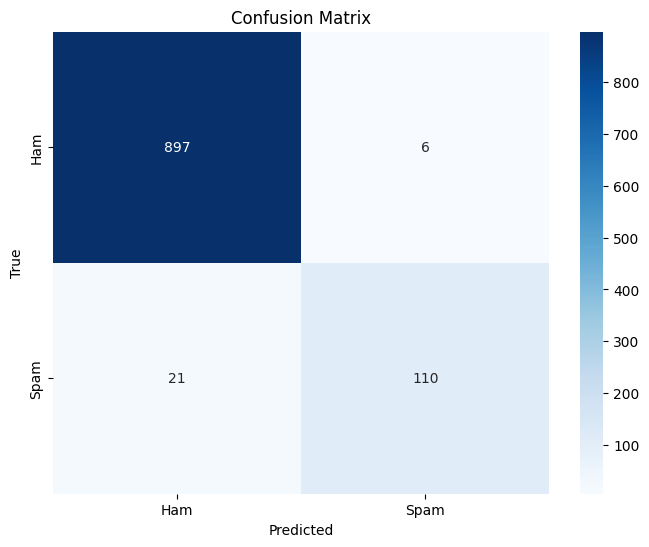

In [ ]:
# Make predictions once
preds = (lstm_trainer.model.predict(x_val_pad) > 0.5).astype("int32").flatten()

# Evaluate
accuracy, precision, conf_matrix, report = Metrics.evaluate(y_val_array, preds)
print(report)
Metrics.plot_confusion_matrix(conf_matrix)

### 6.2.5. Checking against Validation data

In [ ]:
# Show 10 random predictions
samples = random.sample(list(zip(x_val.tolist(), y_val.tolist(), preds)), 10)

print("### LSTM Predictions vs Ground Truth (Validation Set) ###\n")
for i, (msg, true_label, pred_label) in enumerate(samples):
    gt = "Spam" if true_label == 1 else "Ham"
    pred = "Spam" if pred_label == 1 else "Ham"
    print(f"[{i+1}] Message: \"{msg[:60]}...\"")
    print(f"     Ground Truth: {gt} | Predicted: {pred}\n")

### LSTM Predictions vs Ground Truth (Validation Set) ###

[1] Message: "privat 2003 account statement 07973788240 show 800 unredeem ..."
     Ground Truth: Spam | Predicted: Spam

[2] Message: "dont think u got think use got good ni8..."
     Ground Truth: Ham | Predicted: Ham

[3] Message: "xma stori peac xma msg love xma miracl jesu hav bless month ..."
     Ground Truth: Ham | Predicted: Ham

[4] Message: "freemsg record indic may entitl 3750 pound accid claim free ..."
     Ground Truth: Spam | Predicted: Spam

[5] Message: "fren go lor alon wif mum n si lor..."
     Ground Truth: Ham | Predicted: Ham

[6] Message: "forward 88877free entri å£250 weekli comp send word enter 88..."
     Ground Truth: Spam | Predicted: Spam

[7] Message: "fishrman woke earli mrng dark wait amp found sack ful stone ..."
     Ground Truth: Ham | Predicted: Ham

[8] Message: "winner u special select 2 receiv å£1000 cash 4 holiday fligh..."
     Ground Truth: Spam | Predicted: Spam

[9] Message: "kkare c

### 6.2.6. Plotting of Training Curves

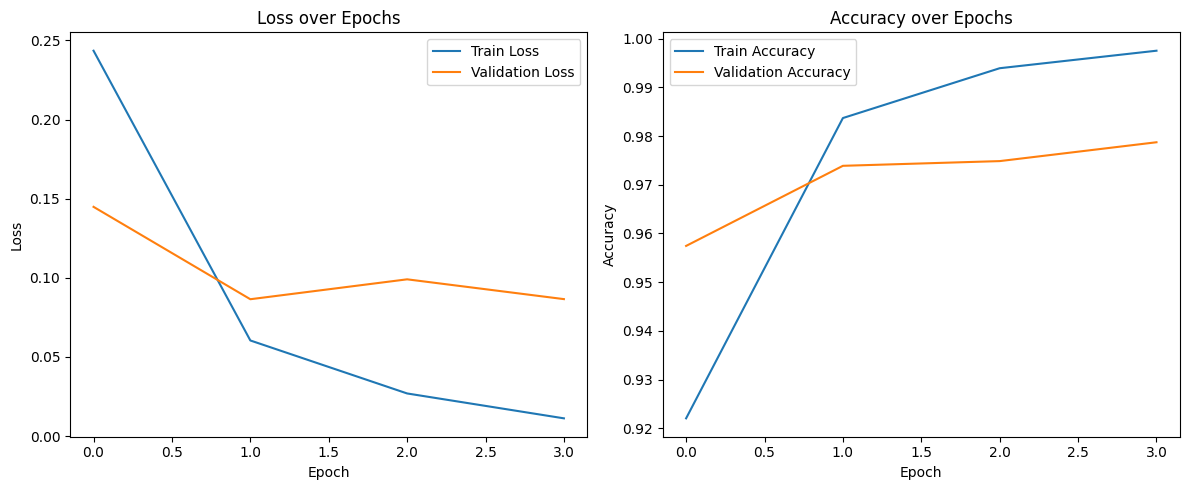

In [ ]:
lstm_trainer.plot_training_curves()

The slight gap between training and validation metrics in Run 7 is expected, as the model achieves near-perfect accuracy on training data while maintaining strong generalization performance on unseen data due to regularization and early stopping.

## 6.3. PyTorch LSTM Model

This section presents the implementation and evaluation of an LSTM model using PyTorch. While functionally similar to the Keras-based LSTM, this version was not selected as the final model due to poorer learning performance and increased implementation complexity.

### 6.3.1. PyTorch LSTM Classifier

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hn, _) = self.lstm(embedded)
        out = self.fc(hn[-1])
        return self.sigmoid(out)

### 6.3.2. Display of Model Architecture

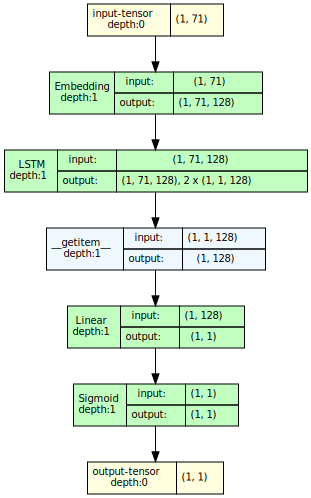

In [ ]:
# Define vocab_size correctly
vocab_size_pt = len(word2idx)

# Initialize model for graph display
pytorch_lstm = LSTMClassifier(vocab_size=vocab_size_pt)
example_input = torch.randint(0, vocab_size_pt, (1, x_train_padded_pt.shape[1]))

# Visualize using torchview
model_graph = draw_graph(pytorch_lstm, input_data=example_input.to(device), expand_nested=True)
model_graph.visual_graph

### 6.3.3. Tuning of Hyperparameters

In [ ]:
# Set hyperparameters
pt_lr = 0.001
pt_wd = 0.0001
pt_epochs = 10

# Instantiate model
pt_model = LSTMClassifier(vocab_size=vocab_size_pt)
pt_model.to(device)

# Define optimizer
pt_optimizer = torch.optim.Adam(pt_model.parameters(), lr=pt_lr, weight_decay=pt_wd)

# Training using the PyTorch LSTMTrainer class
pt_trainer = PyTorchLSTMTrainer(pt_model, device, train_loader, val_loader, pt_epochs, pt_optimizer)
pt_trainer.train()

Epoch [1/10], Train Loss: 0.4528, Train Acc: 85.93%, Val Loss: 0.3694, Val Acc: 87.33%
Epoch [2/10], Train Loss: 0.3805, Train Acc: 87.37%, Val Loss: 0.3683, Val Acc: 87.33%
Epoch [3/10], Train Loss: 0.3804, Train Acc: 87.37%, Val Loss: 0.3681, Val Acc: 87.33%
Epoch [4/10], Train Loss: 0.3822, Train Acc: 87.37%, Val Loss: 0.3678, Val Acc: 87.33%
Epoch [5/10], Train Loss: 0.3818, Train Acc: 87.37%, Val Loss: 0.3682, Val Acc: 87.33%
Epoch [6/10], Train Loss: 0.3814, Train Acc: 87.37%, Val Loss: 0.3705, Val Acc: 87.33%
Epoch [7/10], Train Loss: 0.3828, Train Acc: 87.37%, Val Loss: 0.3678, Val Acc: 87.33%
Epoch [8/10], Train Loss: 0.3808, Train Acc: 87.37%, Val Loss: 0.3691, Val Acc: 87.33%
Epoch [9/10], Train Loss: 0.3810, Train Acc: 87.37%, Val Loss: 0.3701, Val Acc: 87.33%
Epoch [10/10], Train Loss: 0.3791, Train Acc: 87.37%, Val Loss: 0.3678, Val Acc: 87.33%


### 6.3.4. Display Classification Report and Plot Confusion Matrix

              precision    recall  f1-score   support

         Ham       0.87      1.00      0.93       903
        Spam       0.00      0.00      0.00       131

    accuracy                           0.87      1034
   macro avg       0.44      0.50      0.47      1034
weighted avg       0.76      0.87      0.81      1034



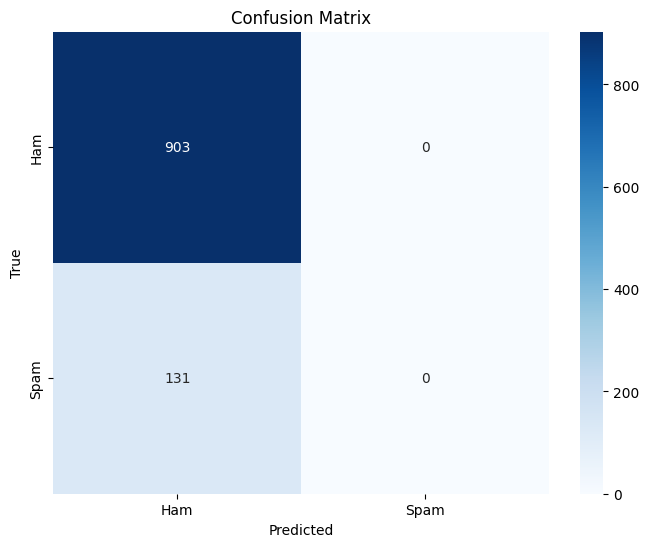

In [ ]:
# Predict on validation set
pt_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = pt_model(inputs).squeeze().cpu()
        predictions = (outputs > 0.5).int().numpy()
        all_preds.extend(predictions)
        all_labels.extend(labels.numpy())

# Evaluate
accuracy, precision, conf_matrix, report = Metrics.evaluate(all_labels, all_preds)
print(report)
Metrics.plot_confusion_matrix(conf_matrix)

### 6.3.5. Checking against Validation data

In [ ]:
# Sample predictions
samples = random.sample(list(zip(x_val.tolist(), all_labels, all_preds)), 10)

print("### LSTM Predictions vs Ground Truth (Validation Set) ###\n")
for i, (msg, true_label, pred_label) in enumerate(samples):
    gt = "Spam" if true_label == 1 else "Ham"
    pred = "Spam" if pred_label == 1 else "Ham"
    print(f"[{i+1}] Message: \"{msg[:60]}...\"")
    print(f"     Ground Truth: {gt} | Predicted: {pred}\n")

### LSTM Predictions vs Ground Truth (Validation Set) ###

[1] Message: "sure sinc parent work tuesday dont realli need cover stori..."
     Ground Truth: Ham | Predicted: Ham

[2] Message: "way school pl send ashley number..."
     Ground Truth: Ham | Predicted: Ham

[3] Message: "dun believ wat..."
     Ground Truth: Ham | Predicted: Ham

[4] Message: "sent price mean ltgt g..."
     Ground Truth: Ham | Predicted: Ham

[5] Message: "hurt n meaning line ever compromis everyth love..."
     Ground Truth: Ham | Predicted: Ham

[6] Message: "fuck babe miss sooooo much wish sleep bed lone go sleep drea..."
     Ground Truth: Ham | Predicted: Ham

[7] Message: "ok ill let noe later n ask call u tmr..."
     Ground Truth: Ham | Predicted: Ham

[8] Message: "wait 4 ì insid da car park..."
     Ground Truth: Ham | Predicted: Ham

[9] Message: "yup msg tat yiju tot group mate co meet today mah im askin ì..."
     Ground Truth: Ham | Predicted: Ham

[10] Message: "loosu go hospit de dont let ca

### 6.3.6. Why PyTorch LSTM Was Not Used as the Final Model

Although a PyTorch-based LSTM was implemented and trained for spam detection, it was **not used in the final model selection** due to several observed limitations:

As shown in **Section 6.3.3 (Tuning of Hyperparameters)**:
- **Stagnant performance**: Despite training for 10 epochs, both training and validation accuracy plateaued at around **87.3%**, indicating that the model quickly stopped learning and failed to make further improvements.
- **Underfitting**: The training loss remained relatively high across epochs, suggesting that the model did not capture the complexity of the input data.

In **Section 6.3.4 (Evaluation and Confusion Matrix)**:
- **Bias toward majority class**: The model was completely biased toward the majority class ("Ham"), predicting all validation samples as "Ham" regardless of their true label.

The confusion matrix further highlights the issue. This shows that the PyTorch LSTM completely failed to identify any spam messages, making it unsuitable for real-world deployment where false negatives (undetected spam) are critical to avoid.


# **7. Testing and Comparison**

This section will compare the performance between **Naive Bayes** and **Keras LSTM** model using test dataset. The **PyTorch LSTM** was excluded from final evaluation due to its poor performance and training stagnation, which made it unsuitable for production-level spam detection.

## 7.1. Testing on Naive Bayes

### Naive Bayes - Test Set Evaluation ###

              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       452
        Spam       1.00      0.78      0.88        65

    accuracy                           0.97       517
   macro avg       0.98      0.89      0.93       517
weighted avg       0.97      0.97      0.97       517



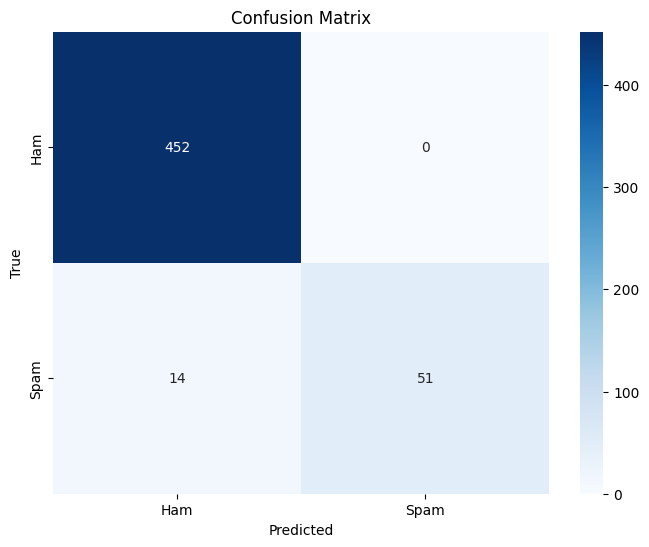

In [ ]:
# Predict on test set using Naive Bayes
nb_test_preds = nb_model.predict(x_test_tfidf)

# Evaluate
nb_test_accuracy, nb_test_precision, nb_test_conf_matrix, nb_test_report = Metrics.evaluate(y_test, nb_test_preds)

print("### Naive Bayes - Test Set Evaluation ###\n")
print(nb_test_report)
Metrics.plot_confusion_matrix(nb_test_conf_matrix)

## 7.2. Testing on Keras LSTM Model

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
### Keras LSTM - Test Set Evaluation ###

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       452
        Spam       0.97      0.94      0.95        65

    accuracy                           0.99       517
   macro avg       0.98      0.97      0.97       517
weighted avg       0.99      0.99      0.99       517



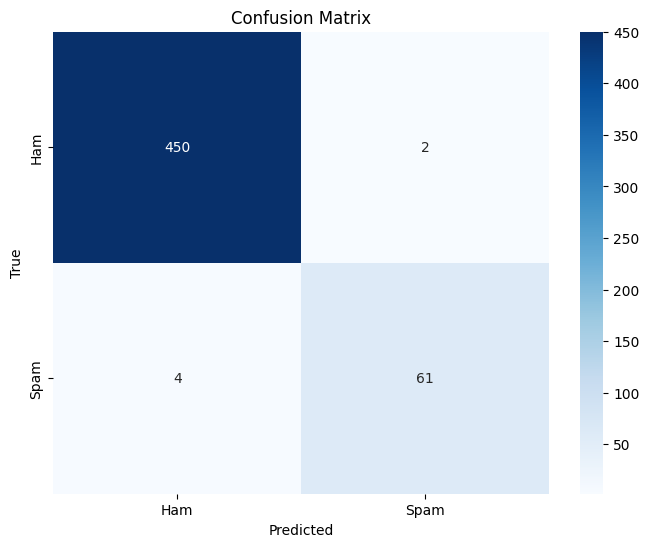

In [ ]:
# Predict on test set using Keras LSTM
lstm_test_preds = (lstm_trainer.model.predict(x_test_pad) > 0.5).astype("int32").flatten()

# Evaluate
lstm_test_accuracy, lstm_test_precision, lstm_test_conf_matrix, lstm_test_report = Metrics.evaluate(y_test_array, lstm_test_preds)

print("### Keras LSTM - Test Set Evaluation ###\n")
print(lstm_test_report)
Metrics.plot_confusion_matrix(lstm_test_conf_matrix)


## 7.3. Comparison Summary

- **Naive Bayes** achieved 97% accuracy with perfect precision for spam (1.00) but suffered from lower recall (0.78), meaning it saw a real spam message but predicted it as a ham.
- **Keras LSTM** achieved a higher accuracy of 99%, with balanced precision (0.97) and higher recall (0.94) for spam, reducing false negatives.
- Naive Bayes misclassified 14 spam messages as ham, whereas Keras LSTM reduced this to only 4 misclassifications (2 ham, 2 spam).
- Keras LSTM had a better f1-score for spam (0.95) compared to Naive Bayes (0.88), showing stronger generalization.

Overall, Keras LSTM demonstrated superior ability to detect spam without sacrificing precision, outperforming Naive Bayes in key metrics.

# **8. Conclusion**

In this project, we implemented and compared three models for SMS spam detection:

- **Naive Bayes**
- **Keras-based LSTM**
- **PyTorch-based LSTM**

Only Naive Bayes and Keras LSTM were selected for final evaluation on the test set.

### Performance Overview

| Model           | Accuracy | Precision (Spam) | Recall (Spam) | F1-Score (Spam) |
|----------------|----------|------------------|----------------|-----------------|
| Naive Bayes    | 0.97     | 1.00             | 0.78           | 0.88            |
| Keras LSTM     | 0.99     | 0.97             | 0.94           | 0.95            |

### Analysis and Insights

The models ranked from highest to lowest performance are:

---

#### 1. **Keras LSTM**

The Keras-based LSTM model delivered the **highest accuracy and most balanced performance**. Its ability to learn sequential dependencies in language allowed it to better identify spam messages while maintaining high precision. It achieved **0.99 accuracy** and **0.95 F1-score** for spam — reducing false negatives significantly. Its performance validates the strength of deep learning for text classification when trained properly on preprocessed data.

---

#### 2. **Naive Bayes**

Naive Bayes performed well with **fast training** and high precision (**1.00**) for spam detection. However, its **recall of 0.78** indicates it failed to capture many spam messages. This is likely due to its simplifying assumption of feature independence, which limits its ability to model contextual patterns found in language. While simple and efficient, it is more prone to false negatives compared to deep learning approaches.

---

#### 3. **PyTorch LSTM**

The PyTorch-based LSTM was implemented and trained, but ultimately **not selected for final evaluation** due to its inferior performance. It consistently plateaued at around **87% accuracy**, showed minimal learning beyond the first epoch, and exhibited signs of underfitting. Furthermore, training and debugging were more complex compared to the high-level Keras API, which made development less efficient.

---

### Final Model Selection

The **Keras LSTM** was chosen as the final model for its:
- Superior accuracy and F1-score
- Better recall without sacrificing precision
- Effective handling of sequence and language patterns

Its balance between accuracy, robustness, and adaptability makes it the most suitable choice for real-world SMS spam detection deployment.